In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
from baseband import dada

In [2]:
puls = fits.open('J0953+0755_2025_11_16_06_05_31_1p5mins_type_0.dada_intensity.fits')
puls.info()

Filename: J0953+0755_2025_11_16_06_05_31_1p5mins_type_0.dada_intensity.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  HISTORY       1 BinTableHDU     74   1R x 29C   [24A, 256A, 8A, 8A, 1J, 1I, 1I, 1I, 1D, 1D, 1J, 1D, 1D, 1D, 1D, 1I, 1I, 1I, 1I, 1I, 32A, 32A, 32A, 256A, 32A, 32A, 1I, 32A, 1I]   
  2  SUBINT        1 BinTableHDU     72   172R x 10C   [1D, 1D, 1D, 1D, 1D, 256D, 256E, 256E, 256E, 524288B]   


# READING THE HEADER (KNOW YOUR DATA)

In [3]:
for i, hdu in enumerate(puls):
    print("\n" + "="*60)
    print(f"HDU {i}: {hdu.name}")
    print("="*60)
    hdu.header.totextfile(sys.stdout)


HDU 0: PRIMARY
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
HDRVER  = '6.7             '   / Header version                                 
FITSTYPE= 'PSRFITS         '   / FITS definition for pulsar data files          
DATE    = '2

In [4]:
sample_time = puls['SUBINT'].header['TBIN']

chan_bw_bin = puls['SUBINT'].header['CHAN_BW']

print("sample_time = " +str( sample_time))


cen_freq = puls['PRIMARY'].header['OBSFREQ']
Band_Width = puls['PRIMARY'].header['OBSBW']

nchan = puls['SUBINT'].header['NCHAN']


sample_time = 0.000248242424242424


In [5]:
start_freq = cen_freq - (Band_Width/2)
end_freq = cen_freq + (Band_Width/2)

In [6]:
data = puls['SUBINT'].data['DATA']

In [7]:
d = data[:,:,0,:]

In [8]:
d.shape

(172, 2048, 256)

In [9]:
psr_data = d.reshape(2048*172, 256)

In [10]:
spectra, fbins = psr_data.shape

# SEE THE SPECTRUM (after removing the bandpass)

In [11]:
start_freq, end_freq

(166.75, 183.25)

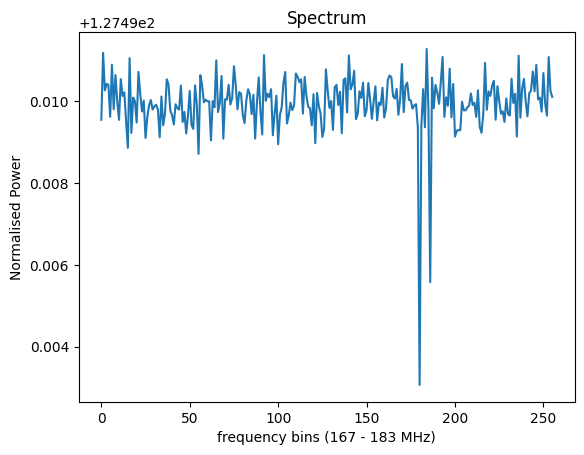

In [12]:
plt.plot(np.mean(psr_data.T, axis = 1));
plt.xlabel("frequency bins (167 - 183 MHz)");
plt.ylabel("Normalised Power");
plt.title("Spectrum");

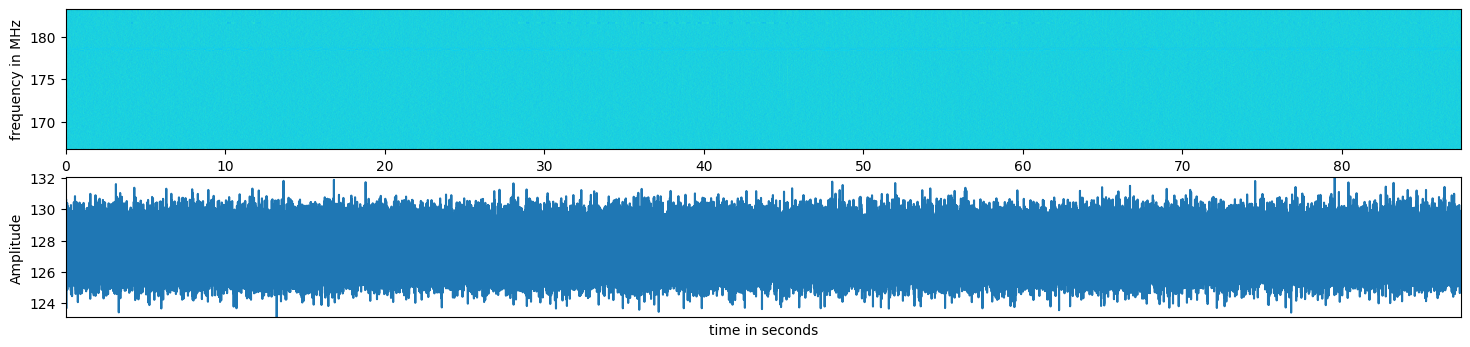

In [13]:
plt.figure(figsize=(18,4))
plt.subplot(2,1,1)
# Viewing Selected Time Segement .
plt.imshow(psr_data.T[:, :],cmap='jet', aspect='auto', origin='lower', extent = [0*sample_time,spectra*sample_time, start_freq, end_freq]);
plt.xlabel("time in seconds")
plt.ylabel("frequency in MHz")
plt.subplot(2,1,2)
plt.plot(np.mean(psr_data.T[:, :], axis = 0));
plt.margins(0,0)
plt.xticks([])
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
plt.show()

In [14]:
(145366 - 143318)//5

409

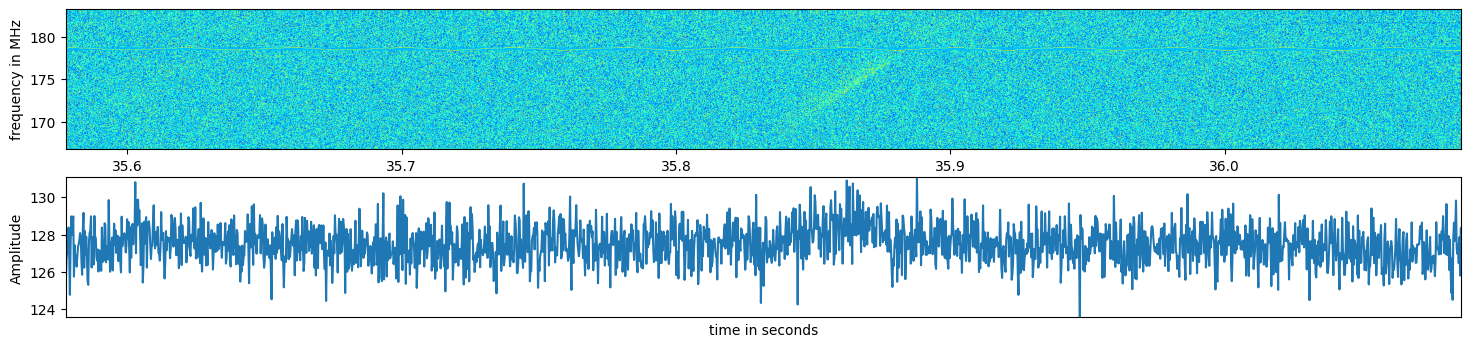

In [15]:
plt.figure(figsize=(18,4))
plt.subplot(2,1,1)
# Viewing Selected Time Segement .
plt.imshow(psr_data.T[:, 143318:145366],cmap='jet', aspect='auto', origin='lower', extent = [143318*sample_time,145366*sample_time, start_freq, end_freq]);
plt.xlabel("time in seconds")
plt.ylabel("frequency in MHz")
plt.subplot(2,1,2)
plt.plot(np.mean(psr_data.T[:, 143318:145366], axis = 0));
plt.margins(0,0)
plt.xticks([])
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
plt.show()

# DE DESPERSION

In [ ]:
def pulsar_ddplan(psr_data, DM):
    def make_frequency_axis(f_center_MHz, bandwidth_MHz, nchan=256):
        df = bandwidth_MHz / nchan
        f_start = f_center_MHz - bandwidth_MHz / 2 + df / 2
        freqs_MHz = f_start + df * np.arange(nchan)
        return freqs_MHz
    def dedispersion_plan(freqs_MHz, DM, f_ref_MHz=None):
        k_DM = 4.148808e3  # MHz^2 pc^-1 cm^3 s

        if f_ref_MHz is None:
            f_ref_MHz = np.max(freqs_MHz)

        delays_sec = k_DM * DM * (
            1.0 / freqs_MHz**2 - 1.0 / f_ref_MHz**2
        )

        return delays_sec

    def delays_to_samples(delays_sec, tsamp):
        return np.rint(delays_sec / tsamp).astype(int)

    def incoherent_dedisperse(data, shifts):
        ntime, nchan = data.shape
        dedispersed = np.zeros_like(data)

        for ch in range(nchan):
            dedispersed[:, ch] = np.roll(
                data[:, ch],
                shifts[ch] 
            )

        return dedispersed

    # Given
    data = psr_data   
    #DM = 2.96927
    tsamp = 0.0002482424242423124  
    f_center = 175     
    bandwidth = 16.5     


    freqs = make_frequency_axis(f_center, bandwidth, nchan=256)

    # Step 2: Dedispersion plan
    delays_sec = dedispersion_plan(freqs, DM)

    # Step 3: Sample shifts
    shifts = delays_to_samples(delays_sec, tsamp)

    # Step 4: Apply dedispersion
    data_dd = incoherent_dedisperse(data, shifts)

    return data_dd

GIVE YOUR DM VALUE (between 1.0 to 5.0): -3


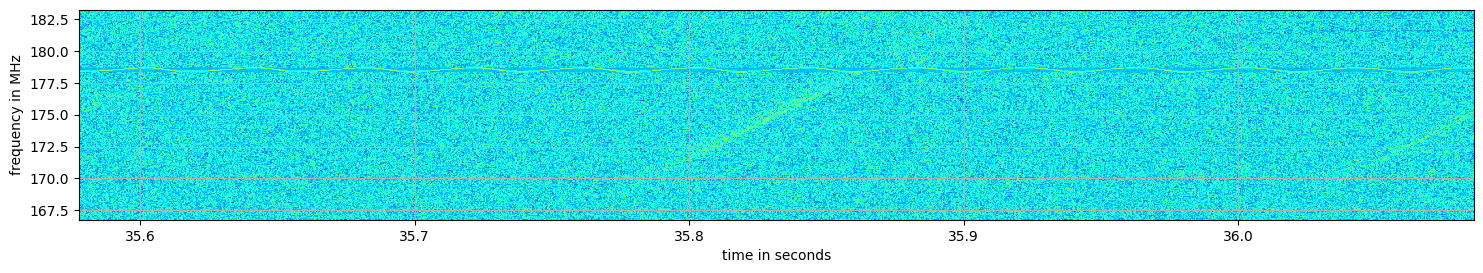

Select one of the following off-pulse region (seconds) (1. [35.6, 35.7], 2 [35.7, 35.8], 3 [35.8, 35.9], 4 FULL RANGE) :  4


MAXIMUM SNR SEEN : 3.385034298773999


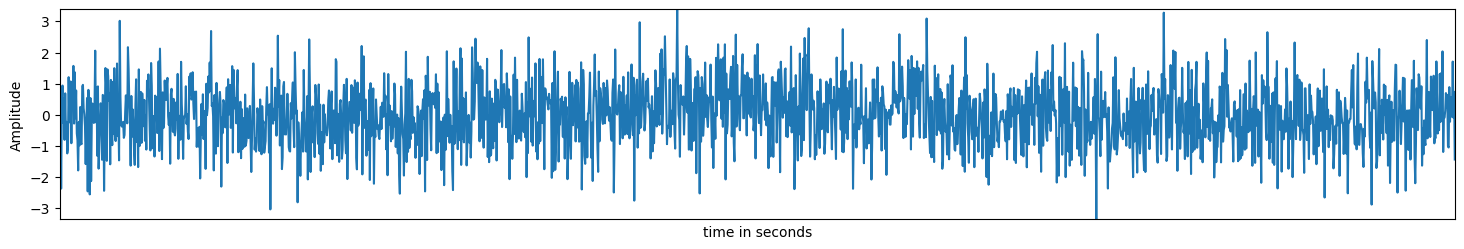

In [ ]:
DM = input("GIVE YOUR DM VALUE (between 1.0 to 5.0):")
plt.figure(figsize=(18,6))
plt.subplot(2,1,1)
data = pulsar_ddplan(psr_data, float(DM))
plt.imshow(data.T[:, 143318:145366],cmap='jet', aspect='auto', origin='lower', extent = [143318*sample_time,145366*sample_time, start_freq, end_freq]);
plt.xlabel("time in seconds");
plt.ylabel("frequency in MHz");
f_col_time_series = np.mean(data.T[:, 143318:145366], axis = 0)
plt.grid()

'''
plt.subplot(3,1,2)
plt.plot(f_col_time_series);
plt.xticks([])
plt.margins(0,0)
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
plt.show()
'''
plt.show()
k = input("Select one of the following off-pulse region (seconds) (1. [35.6, 35.7], 2 [35.7, 35.8], 3 [35.8, 35.9], 4 FULL RANGE) : ")

f_col_time_series_1 = (f_col_time_series-np.mean(f_col_time_series))


if k == 1:
    rms = np.std(f_col_time_series_1[:400])
elif k == 2:
    rms = np.std(f_col_time_series_1[400 : (400*2)])
elif k ==3:
    rms = np.std(f_col_time_series_1[(400*2):(400*3)])
else :
    rms = np.std(f_col_time_series_1[:400*5])
plt.figure(figsize=(18,6));
plt.subplot(2,1,2);
plt.plot(f_col_time_series_1/float(rms));
plt.xticks([])
plt.margins(0,0)
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
print("MAXIMUM SNR SEEN : " + str(max(f_col_time_series_1/float(rms))))


In [57]:
rms

1.0927450275853468

In [72]:
2048*0.5

1024.0